In [1]:
import os

import numpy as np
import torchvision
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from PIL import Image

from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200


In [2]:
BATCH_SIZE = 256
DEVICE = torch.device("cuda")
GLR = 2e-4
DLR = 2e-5
EPOCHES = 50
NDF = 128  # Рамер карты признаков для генератора
NC = 3  # Количество каналов цвета
NZ = 100  # Размер латентного вектора (размерность латентного пространства)

CELEBA_DIR = "img_align_celeba"
WEIGHTS_DIR = "weights"
IMGS_DIR = "res"

os.makedirs(IMGS_DIR, exist_ok=True)

### CSPup block 

In [3]:
class Block(nn.Module):
    def __init__(self, ch, kernel_size=3, stride=1, padding=1):
        super(Block, self).__init__()
        self.conv = nn.Conv2d(ch, ch, kernel_size, stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(ch)
        self.act = nn.Tanh()

    def forward(self, x):
        y = self.conv(x)
        y = self.bn(y)
        return self.act(y)


class CSPup(nn.Module):
    # Standard bottleneck
    def __init__(
        self, c_in, kernel=3, stride=1, pad=1, e=0.5
    ):  # ch_in, ch_out, shortcut, groups, expansion
        super(CSPup, self).__init__()
        self.e = e
        c_out = int(c_in * self.e)

        self.upsamp = nn.ConvTranspose2d(
            c_out, c_out, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.conv1 = Block(c_out, kernel_size=kernel, stride=1, padding=pad)
        self.upsamp1 = nn.ConvTranspose2d(
            c_in, c_out, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.conv2 = Block(c_out, kernel_size=kernel, stride=1)
        self.conv3 = nn.Conv2d(
            c_out, c_out, kernel_size=kernel, stride=stride, padding=pad
        )

    def forward(self, x):
        e = int(x.shape[-1] * self.e)
        y1 = self.upsamp(x[..., :e].permute(0, 3, 1, 2))

        y2 = self.conv1(x[..., e:].permute(0, 3, 1, 2))
        y2 = self.upsamp(y2)
        y2 = self.conv2(y2)
        y2 = self.conv3(y2)

        return (y1 + y2).permute(0, 2, 3, 1)


t = torch.randn(1, 64, 64, 64)  # channels first False
csp = CSPup(64)
csp(t).shape

torch.Size([1, 128, 128, 32])

### cspup_e

In [4]:
class Block(nn.Module):
    def __init__(self, ch, kernel_size=3, stride=1, padding=1):
        super(Block, self).__init__()
        self.conv = nn.Conv2d(ch, ch, kernel_size, stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(ch)
        self.act = nn.Tanh()

    def forward(self, x):
        y = self.conv(x)
        y = self.bn(y)
        return self.act(y)


class CSPup_E(nn.Module):
    # Standard bottleneck
    def __init__(
        self, c_in, kernel=3, stride=1, pad=1, e=0.5
    ):  # ch_in, ch_out, shortcut, groups, expansion
        super(CSPup_E, self).__init__()
        self.e = e
        c_out = int(c_in * self.e)

        self.upsamp = nn.ConvTranspose2d(
            c_out, c_out, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.conv1 = Block(c_out, kernel_size=kernel, stride=1, padding=pad)
        self.upsamp1 = nn.ConvTranspose2d(
            c_in, c_out, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.conv2 = Block(c_out, kernel_size=kernel, stride=1)
        self.conv3 = nn.Conv2d(
            c_out, c_out, kernel_size=kernel, stride=stride, padding=pad
        )

    def forward(self, x):
        _, ch, _, _ = x.shape
        e = int(ch * self.e)
        
        y1 = self.upsamp(x[:, :e, ...])

        y2 = self.conv1(x[:, e:, ...])
        y2 = self.upsamp(y2)
        y2 = self.conv2(y2)
        y2 = self.conv3(y2)

        return (y1 + y2)


t = torch.randn(1, 64, 64, 64)  # channels first False
csp = CSPup_E(64)
csp(t).shape

torch.Size([1, 32, 128, 128])

### Generator & Discriminator

In [5]:
class GAN_Generator(nn.Module):
    def __init__(self):
        super(GAN_Generator, self).__init__()

        self.device = torch.device("cuda:0")
        self.n_blocks = 5
        self.input_shape = 1024

        self.ups = nn.ConvTranspose2d(NZ, self.input_shape, 4, 1, 0)
        self.csp_stack = nn.Sequential(
            *[CSPup(int(self.input_shape / 2**i)) for i in range(self.n_blocks)]
        )
        in_channels = int(self.input_shape / 2 ** (self.n_blocks))
        out_channels = 3
        self.deconv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=3, padding=1, stride=1
        )
        self.activ = nn.Tanh()

    def forward(self, inputs):
        inputs = self.ups(inputs).permute(0, 2, 3, 1)
        inputs = self.csp_stack(inputs)
        inputs = inputs.permute(0, 3, 2, 1)
        inputs = self.activ(self.deconv(inputs))

        return inputs


t = torch.randn(2, 100, 1, 1)
csp = GAN_Generator()
y = csp(t)
y.shape

torch.Size([2, 3, 128, 128])

### gan_gen_e

In [6]:
class GAN_Generator_E(nn.Module):
    def __init__(self):
        super(GAN_Generator_E, self).__init__()

        self.device = torch.device("cuda:0")
        self.n_blocks = 5
        self.input_shape = 1024

        self.ups = nn.ConvTranspose2d(NZ, self.input_shape, 4, 1, 0)
        self.csp_stack = nn.Sequential(
            *[CSPup_E(int(self.input_shape / 2**i)) for i in range(self.n_blocks)]
        )
        in_channels = int(self.input_shape / 2 ** (self.n_blocks))
        out_channels = 3
        self.deconv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=3, padding=1, stride=1
        )
        self.activ = nn.Tanh()

    def forward(self, inputs):
        inputs = self.ups(inputs)
        inputs = self.csp_stack(inputs)
        inputs = self.activ(self.deconv(inputs))

        return inputs


t = torch.randn(2, 100, 1, 1)
csp = GAN_Generator_E()
y = csp(t)
y.shape

torch.Size([2, 3, 128, 128])

In [7]:
class DC_Generator(nn.Module):
    def __init__(self):
        super(DC_Generator, self).__init__()
        self.main = nn.Sequential(
            # вход Z, идет в convolution
            nn.ConvTranspose2d( NZ, NDF * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(NDF * 8, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( NDF * 4, NDF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( NDF * 2, NDF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( NDF, NC, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
m = DC_Generator()
m(torch.rand(1, 100, 1, 1)).shape

torch.Size([1, 3, 64, 64])

In [8]:
class GAN_Discriminator(nn.Module):
    def __init__(self):
        super(GAN_Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(NC, NDF, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(NDF, NDF * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(NDF * 2, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(NDF * 4, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(NDF * 8, NDF * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(NDF * 16, 1, 4, 1, 0, bias=False),
            # nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


t = torch.randn(2, 3, 128, 128)
model = GAN_Discriminator()
model(t).shape

torch.Size([2, 1, 1, 1])

### Create dataloader

In [9]:
class celebaLoader(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dir = dataset_dir
        self.transform = transform
        self.imgs = self.__load()

    def __load(self):
        if not os.path.exists(self.dir):
            raise OSError("No such dataset")
        
        return [os.path.join(self.dir, el) for el in os.listdir(self.dir)]
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = torchvision.io.read_image(self.imgs[idx]) - 127.5
        if self.transform:
            img = self.transform(img)

        return img / 127.5

def collate_fn(batch):
    images = torch.Tensor()
    for im in batch:
        width, height = im.size
        new_size = min(width, height)

        left = (width - new_size) / 2
        top = (height - new_size) / 2
        right = (width + new_size) / 2
        bottom = (height + new_size) / 2

        # Crop the center of the image
        im = im.crop((left, top, right, bottom))
        im = im.resize((128, 128), Image.Resampling.LANCZOS)
        images = torch.cat([images, ToTensor()(im).unsqueeze(0)])

    return images


dataset = celebaLoader(CELEBA_DIR, torchvision.transforms.Resize((NDF, NDF)))
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True
)

# Preload data
# for _ in enumerate(tqdm(dataloader)):
#     continue

### Init models

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# G_model = DC_Generator().to(device)
G_model = GAN_Generator_E().to(DEVICE)
G_model.apply(weights_init)

D_model = GAN_Discriminator().to(DEVICE)
D_model.apply(weights_init)

GAN_Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negativ

In [11]:
# лосс
criterion = nn.BCELoss()

fixed_noise = torch.randn(
    64, NZ, 1, 1, device=DEVICE
)  # Создаем батч с рандомным шумом для генерации

real_label = 1.0
fake_label = 0.0

# оптимизаторы
beta1 = 0.5
D_optim = optim.Adam(D_model.parameters(), lr=DLR, betas=(beta1, 0.999))
G_optim = optim.Adam(G_model.parameters(), lr=GLR, betas=(beta1, 0.999))

In [12]:
writer = SummaryWriter()

### Train loop

In [13]:
# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(EPOCHES):
    for i, batch in enumerate(tqdm(dataloader), 0):

        ############################
        # (1) Учим дискриминатор: максимизируем log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D_model.zero_grad()

        # Для батча
        real_cpu = batch.to(DEVICE)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=DEVICE)

        output = D_model(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Учим на полном фейковом батче
        noise = torch.randn(b_size, NZ, 1, 1, device=DEVICE)
        fake = G_model(noise)
        label.fill_(fake_label)
        
        output = D_model(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        D_optim.step()

        ############################
        # (2) Учим генератор: максимизируем log(D(G(z)))
        ###########################
        G_model.zero_grad()
        label.fill_(
            real_label
        )  # для генератора фейковые метки есть реальные (0 меняем на 1)
        output = D_model(fake).view(-1)

        # Вычислим лосс G основываясь на выходе D
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        G_optim.step()

        # Выводим статистику обучения
        errD = errD.cpu().detach().item()
        errG = errG.cpu().detach().item()
        if i % 50 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    EPOCHES,
                    i,
                    len(dataloader),
                    errD,
                    errG,
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )

            img = fake[0].permute(1, 2, 0).cpu().detach().numpy()
            plt.imshow(img)
            plt.savefig(f"res/{epoch}_{i}.png")

            writer.add_scalars(
                "loss/train/", {"generator_loss": errG, "discriminator_loss": errD}, iters
            )
            writer.add_scalars(
                "misc/train/", {"D(x)": D_x, "D(G(z1))": D_G_z1, "D(G(z2))": D_G_z2}, iters
            )
            # writer.add_scalar(
            #     "loss/train/", errG, iters
            # )
            iters += 50
        
        # Сохраним лоссы
        G_losses.append(errG)
        D_losses.append(errD)

    gm = np.mean(G_losses)

    torch.save(G_model.state_dict(), os.path.join(WEIGHTS_DIR, f"{epoch}_{np.round(gm, 2)}.pt"))
    print(f"epoch: {epoch}  G_loss: {gm}  D_loss: {np.mean(D_losses)}")

    G_losses.clear()
    D_losses.clear()

Starting Training Loop...


  0%|          | 1/792 [00:01<23:32,  1.79s/it]

[0/50][0/792]	Loss_D: 2.1587	Loss_G: 2.4303	D(x): 0.4664	D(G(z)): 0.4323 / 0.2091


  6%|▋         | 51/792 [00:57<13:44,  1.11s/it]

[0/50][50/792]	Loss_D: 31.7362	Loss_G: 15.5480	D(x): 0.5431	D(G(z)): 0.9991 / 0.0000


 13%|█▎        | 101/792 [01:53<12:50,  1.12s/it]

[0/50][100/792]	Loss_D: 11.6900	Loss_G: 3.6565	D(x): 0.0373	D(G(z)): 0.7230 / 0.1049


 19%|█▉        | 151/792 [02:49<11:57,  1.12s/it]

[0/50][150/792]	Loss_D: 6.8836	Loss_G: 2.5393	D(x): 0.1942	D(G(z)): 0.8555 / 0.1216


 25%|██▌       | 201/792 [03:51<12:22,  1.26s/it]

[0/50][200/792]	Loss_D: 5.8427	Loss_G: 2.1490	D(x): 0.1408	D(G(z)): 0.7952 / 0.1529


 32%|███▏      | 250/792 [04:55<13:16,  1.47s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/50][250/792]	Loss_D: 4.9208	Loss_G: 1.7675	D(x): 0.1204	D(G(z)): 0.3507 / 0.2969


 38%|███▊      | 301/792 [05:54<09:54,  1.21s/it]

[0/50][300/792]	Loss_D: 5.6444	Loss_G: 1.7733	D(x): 0.2469	D(G(z)): 0.8794 / 0.2647


 44%|████▍     | 350/792 [06:53<08:06,  1.10s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/50][350/792]	Loss_D: 2.8004	Loss_G: 0.9672	D(x): 0.4541	D(G(z)): 0.7679 / 0.4303


 51%|█████     | 400/792 [07:48<08:23,  1.28s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/50][400/792]	Loss_D: 1.0067	Loss_G: 1.3092	D(x): 0.6425	D(G(z)): 0.2514 / 0.3739


 57%|█████▋    | 450/792 [08:47<06:44,  1.18s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/50][450/792]	Loss_D: 2.3163	Loss_G: 1.3845	D(x): 0.3908	D(G(z)): 0.5893 / 0.2875


 63%|██████▎   | 500/792 [09:49<05:53,  1.21s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/50][500/792]	Loss_D: 2.0287	Loss_G: 1.8865	D(x): 0.3360	D(G(z)): 0.3258 / 0.1977


 69%|██████▉   | 550/792 [10:51<04:54,  1.22s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/50][550/792]	Loss_D: 2.2161	Loss_G: 1.3215	D(x): 0.4407	D(G(z)): 0.5890 / 0.3372


 76%|███████▌  | 600/792 [11:52<03:56,  1.23s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/50][600/792]	Loss_D: 1.5559	Loss_G: 1.1940	D(x): 0.5138	D(G(z)): 0.4804 / 0.3325


 82%|████████▏ | 650/792 [12:54<02:33,  1.08s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/50][650/792]	Loss_D: 2.4148	Loss_G: 1.1105	D(x): 0.4595	D(G(z)): 0.6837 / 0.3880


 88%|████████▊ | 700/792 [13:55<01:45,  1.15s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/50][700/792]	Loss_D: 1.8705	Loss_G: 1.1689	D(x): 0.4598	D(G(z)): 0.5218 / 0.3604


 95%|█████████▍| 750/792 [14:51<00:45,  1.08s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/50][750/792]	Loss_D: 1.8525	Loss_G: 1.0691	D(x): 0.4572	D(G(z)): 0.5571 / 0.3810


100%|██████████| 792/792 [15:34<00:00,  1.18s/it]


epoch: 0  G_loss: 2.809873207641596  D_loss: 4.211856087951949


  0%|          | 0/792 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/50][0/792]	Loss_D: 1.7189	Loss_G: 0.8448	D(x): 0.5040	D(G(z)): 0.5825 / 0.4498


  6%|▋         | 50/792 [01:01<14:27,  1.17s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/50][50/792]	Loss_D: 1.6133	Loss_G: 1.2018	D(x): 0.4985	D(G(z)): 0.5002 / 0.3488


 13%|█▎        | 100/792 [02:06<11:30,  1.00it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/50][100/792]	Loss_D: 1.4901	Loss_G: 0.9796	D(x): 0.5246	D(G(z)): 0.5074 / 0.4003


 19%|█▉        | 150/792 [03:10<13:40,  1.28s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/50][150/792]	Loss_D: 1.9569	Loss_G: 1.3486	D(x): 0.4566	D(G(z)): 0.5974 / 0.3047


 25%|██▌       | 200/792 [04:11<11:59,  1.21s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/50][200/792]	Loss_D: 1.0848	Loss_G: 1.4429	D(x): 0.6927	D(G(z)): 0.4614 / 0.2734


 26%|██▌       | 205/792 [04:17<12:14,  1.25s/it]

In [46]:
G_model = GAN_Generator().to(DEVICE)
G_model.load_state_dict(torch.load("weights_0/4_6.4.pt"))
G_model.eval()
print()

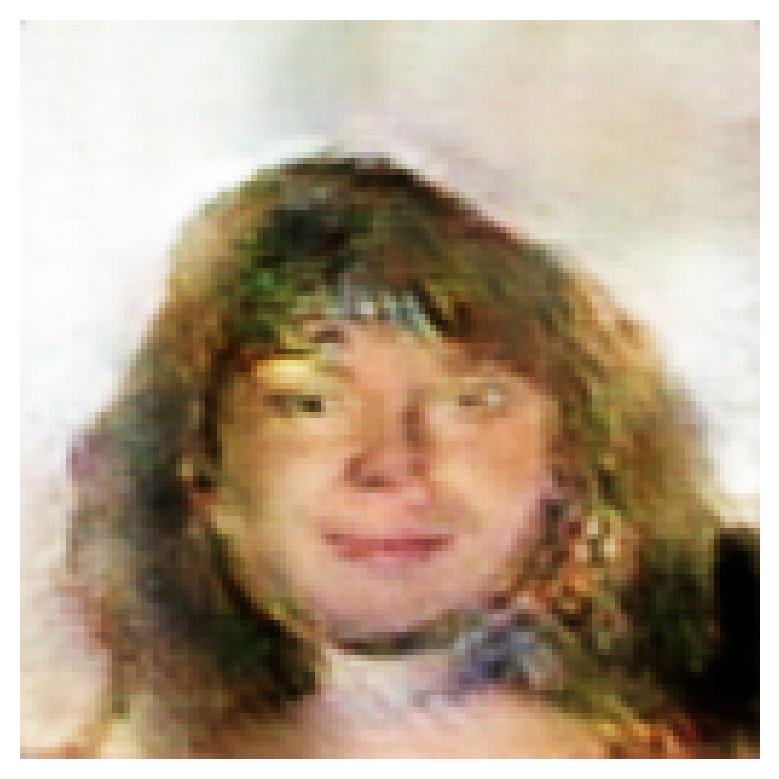

In [61]:
noise = torch.randn(1, NZ, 1, 1, device=DEVICE)
with torch.no_grad():
    fake = G_model(noise).detach().cpu()
    
plt.axis('off')
gr = torchvision.utils.make_grid(fake, nrow=15, normalize=True)
plt.imshow(gr.permute(1, 2, 0),)